In [2]:
import numpy as np
print(np.__version__)


import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

import math

1.25.1
2.0.1


In [3]:
# Quoridor game implementation
import functools
import numpy as np
import itertools
import random
import heapq

class QuoridorState:
    '''
    Quoridor state container class - generalized by size N
    Attributes:
        positions: 2x2 tuple representing the positions of the players
        left_wall: 1x2 tuple representing the number of walls left for each player
        walls: NxNx2 numpy array representing the walls
    '''
    def __init__(self, N: int = 9, n_walls: int = 10, copy: 'QuoridorState' = None):
        self.N = N
        if copy is not None:
            self.N = copy.N
            self.positions = copy.positions.copy()
            self.left_wall = copy.left_wall.copy()
            self.walls = copy.walls.copy()
            self.board = copy.board.copy()
        else:
            self.positions = np.array([[0, self.N // 2], [self.N - 1, self.N // 2]])
            self.left_wall = np.array([n_walls, n_walls])
            self.walls = np.zeros((2, self.N - 1, self.N - 1), dtype=np.int8)
            self.board = self.init_board()


    def init_board(self):
        '''
        Returns a 2N-1x2N-1 numpy array representing the board
        '''
        board = np.zeros((self.N * 2 - 1, self.N * 2 - 1), dtype=np.int8)
        board[1::2, 1::2] = 1
        board[self.positions[0, 0] * 2, self.positions[0, 1] * 2] = 2
        board[self.positions[1, 0] * 2, self.positions[1, 1] * 2] = 3
        return board

    def copy(self):
        return QuoridorState(copy=self)
    
    def encode(self, player):
        '''
        Returns 4xNxN numpy array representing the state
        channel 1: position of player 0
        channel 2: position of player 1
        channel 3: horizontal walls
        channel 4: vertical walls
        '''
        encoded = np.zeros((4, self.N, self.N), dtype=np.float32)
        encoded[player, self.positions[0, 0], self.positions[0, 1]] = 1
        encoded[1 - player, self.positions[1, 0], self.positions[1, 1]] = 1
        encoded[2, :, :] = np.pad(self.walls[0, :, :] == 1, ((0, 1), (0, 1)), 'constant', constant_values=0)
        encoded[3, :, :] = np.pad(self.walls[1, :, :] == 1, ((0, 1), (0, 1)), 'constant', constant_values=0)
        return encoded

class Quoridor:
    '''
    Quoridor rule management class
    '''
    def __init__(self, N, n_walls):
        self.N = N
        self.n_walls = n_walls
    
    def get_initial_state(self):
        '''
        Returns the initial state of the game
        '''
        state = QuoridorState(self.N, self.n_walls)
        return state
    
    @functools.lru_cache(maxsize=None)
    def _search_on_board(self, state: QuoridorState, player):
        '''
        Returns the distance of shortest path to the goal of given player using a* algorithm.
        1 is wall, 0 is path
        if player 0: end at (2N - 2, *)
        if player 1: end at (0, *)
        heuristic: column-distance to the goal
        '''
        board = state.board
        now_pos = state.positions[player] * 2
        queue = []
        heapq.heappush(queue, (2 * self.N - 2, 0, 0, now_pos))
        
        visited = np.zeros((2 * self.N - 1, 2 * self.N - 1), dtype=np.int8)
        temp = 0
        while queue:
            _, _, g, pos = queue.pop()
            if pos[0] < 0 or pos[0] > 2 * self.N - 2 or pos[1] < 0 or pos[1] > 2 * self.N - 2:
                continue
            if board[*pos] == 1 or visited[*pos] == 1:
                continue
            if pos[0] == (2 * self.N - 2) * (1 - player):
                return g
            
            visited[*pos] = 1
            for i in range(4):
                e = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])[i]
                new_pos = pos + e
                h = (2 * self.N - 2 - new_pos[0]) * (1 - player) + (2 * new_pos[0]) * player
                heapq.heappush(queue, (h + g + 1, temp := temp+1, g + 1, pos + e))
        
        return -1


    def is_valid_wall(self, state: QuoridorState):
        '''
        Returns True if the state is valid, False otherwise
        Conditions for a valid state:
            - Walls are not blocking the path to the goal
        '''
        return self._search_on_board(state, 0) != -1 and self._search_on_board(state, 1) != -1
    
    def _search_valid_moves(self, state: QuoridorState, player):
        '''
        Returns a list of valid moves from the given position using dfs
        1 is wall, 0 is path
        2 is player 0, 3 is player 1
        stack: [(pos, n_step)]
        n_step stops at 2
        reset step when board[pos] == 2 or 3
        '''
        board = state.board
        now_pos = state.positions[player] * 2
        movable = []
        stack = []
        stack.append((now_pos, 0))
        visited = np.zeros((2 * self.N - 1, 2 * self.N - 1), dtype=np.int8)
        while len(stack) > 0:
            pos, step = stack.pop()
            if pos[0] < 0 or pos[0] > 2 * self.N - 2 or pos[1] < 0 or pos[1] > 2 * self.N - 2:
                continue
            if board[*pos] == 1 or visited[*pos] == 1:
                continue
            if board[*pos] == 2 or board[*pos] == 3:
                step = 0
            visited[*pos] = 1
            if step == 2:
                movable.append(pos // 2)
                continue
            for e in np.array([[-1, 0], [1, 0], [0, -1], [0, 1]]):
                stack.append((pos + e, step + 1))

        return movable


    def is_valid_move(self, state: QuoridorState, next_pos, player):
        '''
        Returns True if the next state is a valid move, False otherwise
        Conditions for a valid move:
            - The player is moving to a valid position
        '''
        cvt_pos = np.array(next_pos)
        if any([np.array_equal(cvt_pos, val_mov) for val_mov in self._search_valid_moves(state, player)]):
            return True
        else:
            return False


    def get_next_state(self, state: QuoridorState, action: tuple, player: int):
        '''
        Returns the next state of the game given the current state and action
        '''
        action_type, action_value = action
        next_state = QuoridorState(copy=state)
        if action_type == 0:
            if self.is_valid_move(next_state, action_value, player):
                next_state.board[*next_state.positions[player] * 2] = 0
                next_state.board[*np.array(action_value) * 2] = player + 2
                next_state.positions[player] = action_value
                return next_state
            else:
                # print('Invalid move')
                return None
        else:
            if next_state.left_wall[player] == 0:
                # print('No wall left')
                return None
            
            hv = action_type - 1
            row, col = action_value
            if next_state.walls[hv, row, col] != 0:
                # print('Invalid wall')
                return None
            
            next_state.walls[hv, row, col] = 1
            next_state.walls[1 - hv, row, col] = -1
            if hv == 0 and col > 0:
                next_state.walls[0, row, col - 1] = -1
            if hv == 1 and row > 0:
                next_state.walls[1, row - 1, col] = -1
            if hv == 0 and col < self.N - 2:
                next_state.walls[0, row, col + 1] = -1
            if hv == 1 and row < self.N - 2:
                next_state.walls[1, row + 1, col] = -1
            next_state.board[
                row * 2 - hv + 1 : row * 2 + hv + 2,
                col * 2 - (1 - hv) + 1 : col * 2 + (1 - hv) + 2
            ] = 1
            next_state.left_wall[player] -= 1
            if not self.is_valid_wall(next_state):
                # print('Invalid wall')
                return None

            return next_state

    def get_valid_actions(self, state: QuoridorState, player: int):
        moves = self._search_valid_moves(state, player)
        walls = [
            (hv, (r, c))
            for hv in range(2) for r in range(self.N - 1) for c in range(self.N - 1) 
            if self.get_next_state(state, (hv + 1, (r, c)), player) is not None
        ]
        actions = np.zeros((3, self.N, self.N))
        for move in moves:
            actions[0, *move] = 1
        for hv, p in walls:
            actions[1 + hv, *p] = 1
        return actions

    def check_win(self, state: QuoridorState, player):
        '''
        Returns True if the player wins, False otherwise
        '''
        if state.positions[player][0] == (self.N - 1) * (1 - player):
            return True
        else:
            return False
    
    def get_draw_value(self, state: QuoridorState, player: int):
        '''
        Returns the reward of the given state. Possibly value can be heuristic, not only win-lose.
        '''
        p_value = self._search_on_board(state, player)
        o_value = self._search_on_board(state, 1 - player)
        return p_value / (p_value + o_value)
        
    def get_value_and_terminated(self, state: QuoridorState, player: int, turn_count: int):
        '''
        Returns whether the game is terminated and the reward of the given state.
        If the game progresses more than 50 turns, the game is forced to terminate.
        '''
        if turn_count > 50:
            return True, True, self.get_draw_value(state, player)
        if self.check_win(state, player):
            return True, False, 1
        else:
            return False, False, 0
        

def parse_cmd(cmd: str) -> tuple:
    s = cmd.split(' ')
    if s[0] == 'move':
        return 0, (int(s[1]), int(s[2]))
    elif s[0] == 'wall':
        return 1 + s[1], (int(s[2]), int(s[3]))
    else:
        raise ValueError('Invalid action type')


In [4]:
# Model implementation for AlphaZero
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.conv2 = nn.Conv2d(n_channels, n_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(n_channels)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual
        x = F.relu(x)
        return x

class QuoridorNet(nn.Module):
    def __init__(self, game: Quoridor, num_resBlocks, n_channels):
        super().__init__()
        self.start_block = nn.Sequential(
            nn.Conv2d(4, n_channels, 3, padding=1),
            nn.BatchNorm2d(n_channels),
            nn.ReLU()
        )
        self.backbone = nn.Sequential(
            OrderedDict(
                [('backbone_resblock_{}'.format(i), ResBlock(n_channels)) for i in range(num_resBlocks)]
            
            )
        )

        self.policy_head = nn.Sequential(
            nn.Conv2d(n_channels, n_channels, 1, padding=0),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            nn.Conv2d(n_channels, 3, 1, padding=0),
            nn.Sigmoid(),
        )

        self.value_head = nn.Sequential(
            nn.Conv2d(n_channels, 3, 1, padding=0),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.N * game.N, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.start_block(x)
        x = self.backbone(x)
        p = self.policy_head(x)
        v = self.value_head(x)
        return p, v

In [5]:
import random
from itertools import product, chain

import tqdm


class Node:
    def __init__(
            self,
            game: Quoridor,
            args,
            state: QuoridorState,
            player,
            turn_count: int,
            parent: 'Node' = None,
            action_taken = None):
        
        self.game = game
        self.args = args
        self.state = state
        self.player = player
        self.turn_count = turn_count
        self.parent = parent
        self.action_taken = action_taken

        self.children: list['Node'] = []
        self.expandable_actions = self.game.get_valid_actions(self.state, self.player)

        self.visit_count = 0
        self.total_value = 0

    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self) -> 'Node':
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_ucb = ucb
                best_child = child

        return best_child

    def get_ucb(self, child: 'Node'):
        q_value = child.total_value / (child.visit_count + 1e-8)
        return q_value + self.args['C'] * math.sqrt(math.log(self.visit_count) / (child.visit_count + 1e-8))
    

    def expand(self, actions, policy):
        for action in zip(*np.where(actions == 1.0)):
            if policy[*action] > 0.0:
                child_state = self.state.copy()
                a_t, r, c = action
                child_state = self.game.get_next_state(child_state, (a_t, (r, c)), 1 - self.player)

                child = Node(self.game, self.args, child_state, 1 - self.player, self.turn_count + 1, self, action)
                self.children.append(child)

    def backpropagate(self, value, is_draw):
        self.visit_count += 1
        if is_draw:
            self.total_value += value * self.args['draw_discount']
        else:
            self.total_value += value

        if self.parent is not None:
            self.parent.backpropagate(value, is_draw)


class MCTS:
    def __init__(self, game: Quoridor, args, model) -> None:
        self.game = game
        self.args = args
        self.model = model

    def search(self, state, player):
        root = Node(self.game, self.args, state, 1 - player, 0)

        for search in tqdm.trange(self.args['n_searches']):
            # print(search)
            node = root

            while node.is_fully_expanded():
                # print(node.expandable_actions, node.children)
                node = node.select()

            is_terminal, is_draw, value = self.game.get_value_and_terminated(node.state, 1 - node.player, node.turn_count)

            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(node.state.encode(1 - node.player)).unsqueeze(0)
                )
                policy = torch.flatten(policy, start_dim=1, end_dim=3)
                policy = torch.softmax(policy, axis=1).squeeze(0).detach()
                policy = torch.reshape(policy, (3, self.game.N, self.game.N)).numpy()
                
                valid_moves = self.game.get_valid_actions(node.state, 1 - node.player)
                policy *= valid_moves
                policy /= np.sum(policy)

                value = value.unsqueeze(0).item()

                node.expand(valid_moves, policy)
                
            node.backpropagate(value, is_draw)
        
        action_probs = np.zeros((3, self.game.N, self.game.N), dtype=np.float32)
        for idx, child in enumerate(root.children):
            action_probs[*child.action_taken] = child.total_value / (child.visit_count + 1e-8)
        action_probs /= np.sum(action_probs, axis=(0, 1, 2))
        return action_probs


In [6]:
import matplotlib.pyplot as plt


def plot_policy(policy, state: QuoridorState, player):
    if policy is None:
        policy = np.zeros((3, state.N, state.N))
    plt.figure(num=0)
    plt.axis()
    rect = plt.Rectangle((-0.5, -0.5), state.N, state.N, fc='w', ec='k')
    plt.gca().add_patch(rect)
    
    for i in range(state.N):
        for j in range(state.N):
            rate = float(policy[0, i, j])
            color = np.array([1-rate, 0, rate, 1]) if policy[0, i, j] > 0.0 else 'w'
            rect = plt.Rectangle((i-0.3, j-0.3), 0.6, 0.6, fc=color, ec='k')
            plt.gca().add_patch(rect)

    for i in range(state.N - 1):
        for j in range(state.N - 1):
            rate = float(policy[0, i, j])
            color = np.array([1-rate, 0, rate, 1]) if state.walls[0, i, j] != 1 else 'k'
            rect = plt.Rectangle((i+0.5-0.1, j+0.5-0.5), 0.2, 1, fc=color, ec='k')
            plt.gca().add_patch(rect)
            
            rate = float(policy[0, i, j])
            color = np.array([1-rate, 0, rate, 1]) if state.walls[1, i, j] != 1 else 'k'
            rect = plt.Rectangle((i+0.5-0.5, j+0.5-0.1), 1, 0.2, fc=color, ec='k')
            plt.gca().add_patch(rect)

            rect = plt.Rectangle((i+0.5-0.1, j+0.5-0.1), 0.2, 0.2, fc='k', ec='k')
            plt.gca().add_patch(rect)



    circle = plt.Circle((state.positions[0, 0], state.positions[0, 1]), 0.1, fc='g' if player == 0 else 'w', ec='k')
    plt.gca().add_patch(circle)
    circle = plt.Circle((state.positions[1, 0], state.positions[1, 1]), 0.1, fc='g' if player == 1 else 'k', ec='k')
    plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

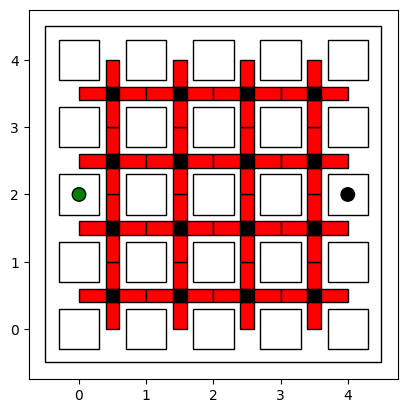

 80%|████████  | 8/10 [00:06<00:01,  1.15it/s]


KeyboardInterrupt: 

In [7]:
quoridor = Quoridor(5, 6)

args = {
    'C': 1.4,
    'n_searches': 10,
    'draw_discount': 0.2,
}

model = QuoridorNet(quoridor, 1, 5)
model.eval()

mcts = MCTS(quoridor, args, model)

state = quoridor.get_initial_state()

player = 0
plot_policy(None, state, player)
while True:
    mcts_probs = mcts.search(state, player)
    action = np.unravel_index(np.argmax(mcts_probs), mcts_probs.shape)

    a_t, r, c = action
    new_state = quoridor.get_next_state(state, (a_t, (r, c)), player)

    if new_state is None:
        print(action)
        print(quoridor.get_valid_actions(new_state, player))

    plot_policy(mcts_probs, new_state, player)

    state = new_state

    is_terminal = quoridor.check_win(state, player)

    if is_terminal:
        print('Player {} wins'.format(player))
        break


    player = 1 - player


In [18]:
class AlphaZero:
    def __init__(self, model: nn.Module, optimizer, game: Quoridor, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)

    def selfplay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()

        while True:
            mcts_probs = self.mcts.search(state, player)
            memory.append((state, mcts_probs, player))

            best_action = np.unravel_index(np.argmax(mcts_probs), mcts_probs.shape)
            a_t, r, c = best_action
            state = quoridor.get_next_state(state, (a_t, (r, c)), player)

            is_terminal, _, value = self.game.get_value_and_terminated(state, player, 0)

            if is_terminal:
                return_memory = []
                for hist_state, hist_mcts_prob, hist_player in memory:
                    hist_value = value if hist_player == player else 1 - value
                    return_memory.append((hist_state.encode(hist_player), hist_mcts_prob, hist_value))
                return return_memory

            player = 1 - player

    def train(self, memory):
        pass

    def learn(self):
        for i in range(self.args['n_iterations']):
            memory = []
            self.model.eval()
            
            for selfplay_i in range(self.args['n_selfplay_iterations']):
                memory.extend(self.selfplay())
            
            self.model.train()
            for epoch in range(self.args['n_epochs']):
                self.train(memory)
            
            torch.save(self.model.state_dict(), f'./model_{i}.pt')
            torch.save(self.optimizer.state_dict(), f'./optimizer_{i}.pt')


In [20]:
quoridor = Quoridor(3, 6)

model = QuoridorNet(quoridor, 3, 3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

args = {
    'C': 2,
    'n_searches': 10,
    'n_iterations': 3,
    'n_selfplay_iterations': 10,
    'n_epochs': 4,
}

alphazero = AlphaZero(model, optimizer, quoridor, args)
alphazero.learn()

100%|██████████| 10/10 [00:00<00:00, 1569.90it/s]
